In [1]:
# A Jupyter notebook for generating ploidy-seq scatter plots which show
# Class I and Class II unbalanced vs alpha duplicates.

In [2]:
import matplotlib.pyplot as plt
from math import atan2, degrees
import numpy as np
# command for showing matplotlib plots within the jupyter notebook
%matplotlib inline
import pandas as pd # utilities for parsing input files

In [3]:
# Define colors, resolutions, etc.

# Class I
C1_color = '#ffae42' # orange
C1_outline = '#f58c00' # dark orange

# Class II
C2_color = '#4293ff' # blue
C2_outline = '#0069f5' # dark blue

# Regression
reg_color = '#ff4293' # magenta

# Resolution for figures (dots per inch)
DPI=300

# Minimum number of reads in a GO term
GO_CUTOFF = 20
MN_CUTOFF = 10

# Point sizes
NONE_PSIZE = 25
CLASS_PSIZE = 35

In [4]:
def calculate_r2(c1, c2, x, y):
    """Calculate r^2 value
    """
    coeffs = (c1, c2)
    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)
    return (ssreg/sstot)**.5 #### IMPORTANT: THIS IS ACTUALLY RETURNING THE r VALUE, NOT r^2 ####

def truncate_float(number, digits_past_decimal=4):
    """Take a float and return that number as a string with a certain number of digits.
    """
    n = str(number)
    if "." in n:
        i = n.find('.')
        j = digits_past_decimal+i+1
        if len(n) > j:
            return n[:j]
        else:
            return n
    else:
        return n

In [5]:
# Read input files
# df_go = pd.read_excel('../data/duplication_history/GO_term_dup_history.xlsx',
#                       sheet_name=1)
df_go = pd.read_csv('../data/final_figures_input/WGDvsSSD_class.txt', sep='\t', header=0)
df_mn = pd.read_excel('../data/duplication_history/Metab_Networks_dup_history.xlsx', sheet_name=0)

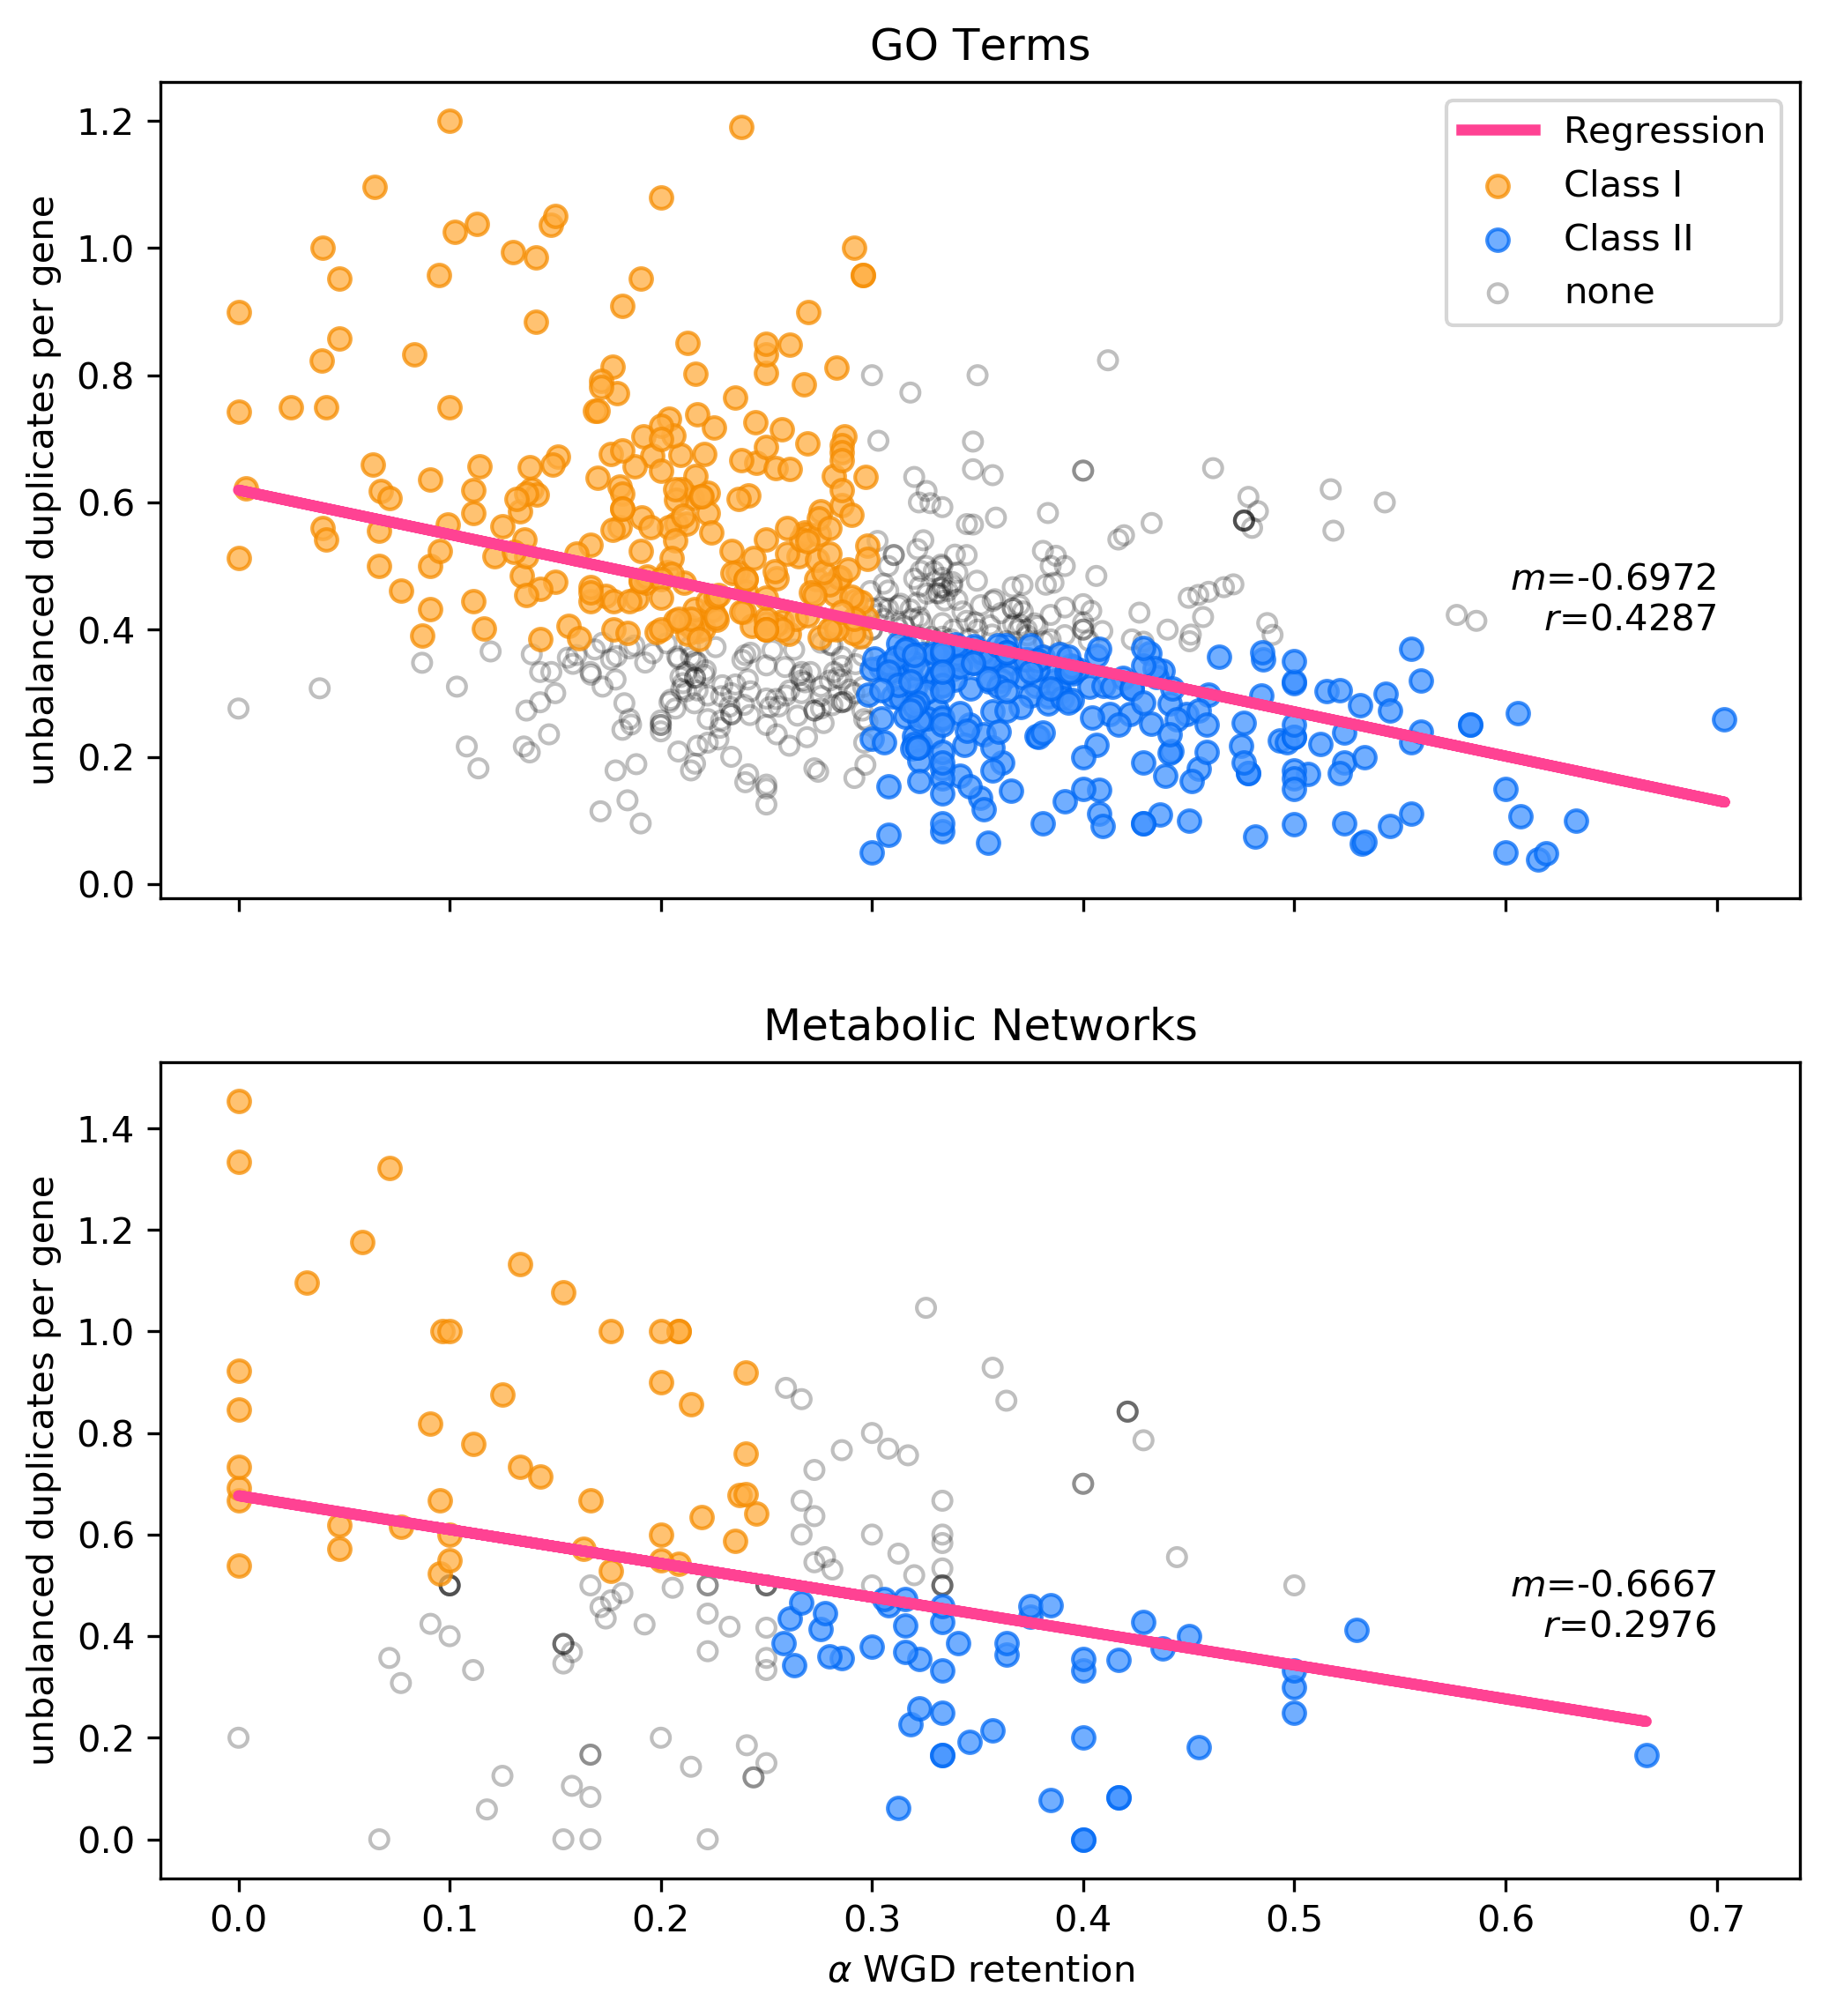

In [6]:
####################
###   Plotting   ###
####################

# Define axes on which the two plots will show up:
# GO terms will go on the left (ax1)
# Metabolic networks will go on the right (ax2)
# sharey=True will make them have the same y axis
# figsize (w, h) is in inches
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,9), 
                             dpi=DPI, facecolor='w', edgecolor='k')

####### First, we will tackle GO terms #######

# Empty arrays that will store our coordinates
c1x, c1y = [], [] # arrays to store Class I values (x and y)
c2x, c2y = [], [] # arrays to store Class II values (x and y)
nx, ny = [], [] # arrays to store remaining values (x and y)

# Iterate through all rows of the table (i.e all GO terms)
# in order to split all terms into one of the three groups we care about:
# Class I, Class II, and none.
# We split into groups so that we can plot them with different colors/opacities/layerings.
for index, row in df_go.iterrows():
    # Assign coordinates for terms in Class I
    if row['Class'] == 'I':
        c1x.append(row['WGD'])
        c1y.append(row['SSD'])
    # Assign coordinates for terms in Class II
    elif row['Class'] == 'II':
        c2x.append(row['WGD'])
        c2y.append(row['SSD'])
    # Assign coordinates for terms in neither class
    else:
        nx.append(row['WGD'])
        ny.append(row['SSD'])

### Regression calculation ###
# define two separate arrays that will be used in the calc
x = np.array(df_go['WGD'])
y = np.array(df_go['SSD'])
# remove all 'NaN's from the arrays
idx = np.isfinite(x) & np.isfinite(y)
# Run the polynomial regression (1st degree -> linear)
m, b = np.polyfit(x[idx], y[idx], 1)
r2a = calculate_r2(m, b, x[idx], y[idx])
######

### Plotting ###
# Start with a scatter plot for each of the three groups
ax1.scatter(c1x, c1y, facecolors=C1_color, edgecolors=C1_outline, 
            alpha=.75, zorder=3, label='Class I', s=CLASS_PSIZE)
ax1.scatter(c2x, c2y, facecolors=C2_color, edgecolors=C2_outline, 
            alpha=.75, zorder=2, label='Class II', s=CLASS_PSIZE)
ax1.scatter(nx, ny, facecolors='none', edgecolors='#000000', 
            alpha=0.25, zorder=1, label='none', s=NONE_PSIZE)
# Plot the regression line
ax1.plot(x, b + m * x, '-', zorder=4, c=reg_color, lw=3, label='Regression')
# Add labels
ax1.set_ylabel('unbalanced duplicates per gene')
ax1.set_title('GO Terms')
ax1.legend(loc='best', prop={'size': 10})
ax1.text(0.7, 0.4, 
         '$m$={}\n$r$={}'.format(truncate_float(m), truncate_float(r2a)), 
         bbox=dict(facecolor='#FFFFFF', alpha=.75, edgecolor='none'), 
         fontsize=10, 
         ha='right')





####### Next, we will tackle metabolic networks #######
# We model this after the previous code

# Empty arrays that will store our coordinates
c1x, c1y = [], [] # arrays to store Class I values (x and y)
c2x, c2y = [], [] # arrays to store Class II values (x and y)
nx, ny = [], [] # arrays to store remaining values (x and y)

# Iterate through all rows of the table (i.e all GO terms)
# in order to split all terms into one of the three groups we care about:
# Class I, Class II, and none.
# We split into groups so that we can plot them with different colors/opacities/layerings.
for index, row in df_mn.iterrows():
    # Filter at count = 10 (default)
    if row['Count of PATHWAY NAME'] >= MN_CUTOFF:
        # Assign coordinates for terms in Class I
        if row['Class'] == 'I':
            c1x.append(row['alpha'])
            c1y.append(row['unbalanced'])
        # Assign coordinates for terms in Class II
        elif row['Class'] == 'II':
            c2x.append(row['alpha'])
            c2y.append(row['unbalanced'])
        # Assign coordinates for terms in neither class
        else:
            nx.append(row['alpha'])
            ny.append(row['unbalanced'])

### Regression calculation ###
# define two separate arrays that will be used in the calc
x = np.array(df_mn['alpha'])
y = np.array(df_mn['unbalanced'])
# remove all 'NaN's from the arrays
idx = np.isfinite(x) & np.isfinite(y)
# Run the polynomial regression (1st degree -> linear)
m, b = np.polyfit(x[idx], y[idx], 1)
r2b = calculate_r2(m, b, x[idx], y[idx])
######

### Plotting ###
# Start with a scatter plot for each of the three groups
ax2.scatter(c1x, c1y, facecolors=C1_color, edgecolors=C1_outline, 
            alpha=.75, zorder=3, label='Class I', s=CLASS_PSIZE)
ax2.scatter(c2x, c2y, facecolors=C2_color, edgecolors=C2_outline, 
            alpha=.75, zorder=2, label='Class II', s=CLASS_PSIZE)
ax2.scatter(nx, ny, facecolors='none', edgecolors='#000000', 
            alpha=0.25, zorder=1, s=NONE_PSIZE)
# Plot the regression line
ax2.plot(x, b + m * x, '-', zorder=4, c=reg_color, lw=3)
# Add labels
ax2.set_title('Metabolic Networks')
ax2.set_ylabel('unbalanced duplicates per gene')
ax2.set_xlabel('$\\alpha$ WGD retention')


ax2.text(0.7, 0.4, 
         '$m$={}\n$r$={}'.format(truncate_float(m), truncate_float(r2b)), 
         bbox=dict(facecolor='#FFFFFF', alpha=.75, edgecolor='none'), 
         fontsize=10, 
         ha='right')


plt.savefig('../figures/dup_history_GO_and_MN.png')
# plt.show()